# Project 4: West Nile Virus Analysis

## Part 2 - Modelling and Evaluation

In this notebook we will build the classification models to predict the presence of West Nile Virus in a trap on a given date. The data imported here is cleaned in Part I of this project. The virus only spreads to humans through mosquitoes and thus looking at the distribution of mosquito population across city, should be a good predictor of virus. Mosquito growth rates can vary with weather factors like $-$ temperature, precipitation. The mosquito life cycle changes with this seasonal changes and we should be able to use this data to predict the presence of virus. Location in the city is also a relevant feature that can have large impact on our modelling results.

**Modelling**

This is a binary classification problem where we predict if the West Nile Virus is detected (positive class) in an observation or not (negative class). These models that predict highly unbalanced classes can suffer from underfit on the minority class and metrics can be really worse depending on the output goal. One of the techniques used in this project is SMOTE. It is short for _Synthetic Minority Oversampling TEchnique_, which means we oversample the minority class (for training data) so that the two output classes are balanced.

Training with this newly balanced class dataset does come with its own caveats, e.g., the synthetic data generated is not representative of the real-world scenario where mostly the class distribution would be uneven, and this can lead to overfitting the model on the minority class. Then when we fit the validation/test data, our model might not perform as well. However, benefits of using the oversampling technique outweighs using not using it, as shown later.

We start with Logistic Regression, which is a commonly used classification model, and than try a bunch of tree based models, like, Extra Trees, Random Forests, and boosting, like AdaBoost, XGBoost. For a classification problem of this type and distribution, where we have many seemingly correlated features, decision trees can be a great way to classify them. Although, on there own, there is a very high probablity of them overfitting and thus we use other techniques such as bootstrapping along with ensemble methods like bagging classifier to overcome this issue.

**Evaluation**

The most common metric for classification problems is accuracy. But some times, accuracy can give a fake sense of success, especially when measured on highly unbalanced classes like in this project. Say our target class distribution is 98-2, then predicting every target equal to majority class gives us 98% accuracy, which is not realistic. Thus, we can look at other widely used metric, ROC-AUC, which can give us more information because it plots true positive rate vs false positive rate. Intuitively, it explains how good the model is at separating the two classes. In this project, it is crucial to reduce the number of observations that are predicted to not have the virus when they actually have. To maximise the help we can provide to the city authorities, it is imperative that we don't miss many sites which might have the virus.


#### Contents

The contents of this notebook are as follows:
- [Imports](#Imports)

- [Modelling](#Modelling)

- [Evaluation](#Evaluation)

- [Recommendations and Conclusion](#Recommendations-and-Conclusion)

## Imports

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import time
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline, make_pipeline

In [2]:
# Function to save kaggle submissions for WnvPresent probabilities
def get_kaggle_format(prediction_probs):
    # load the sample submission file
    sub = pd.read_csv('../datasets/sampleSubmission.csv')
    sub['WnvPresent'] = prediction_probs
    
    # Output filename for kaggle submission
    i = 0
    while os.path.exists(f"../datasets/kaggle_sub_{i}.csv"):
        i += 1
    filename = f"../datasets/kaggle_sub_{i}.csv"
    
    # Save the DataFrame to a file
    sub.to_csv(filename, index=False)
    print(f'File name: {filename}')

In [3]:
# import data
pd.set_option('display.max_columns', None)
train = pd.read_csv('../datasets/combined_cleaned.csv')
test = pd.read_csv('../datasets/test_cleaned.csv')

In [4]:
train

,date,latitude,longitude,wnv_present,species_ohe,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed,daylight,r_humid,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc,tavg_5,tavg_10,tavg_14,tavg_28,precip_total_5,precip_total_10,precip_total_14,precip_total_28,r_humid_5,r_humid_10,r_humid_14,r_humid_28,year,month,week,day
0,2007-05-29,41.731922,-87.677512,0,3.0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,65.6,67.25,64.678571,63.714286,0.151,0.08575,0.06875,0.055000,172.671291,196.319405,208.835422,207.239818,2007,5,22,1
1,2007-05-29,41.954690,-87.800991,0,2.0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,65.6,67.25,64.678571,63.714286,0.151,0.08575,0.06875,0.055000,172.671291,196.319405,208.835422,207.239818,2007,5,22,1
2,2007-05-29,41.974089,-87.824812,0,2.0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,65.6,67.25,64.678571,63.714286,0.151,0.08575,0.06875,0.055000,172.671291,196.319405,208.835422,207.239818,2007,5,22,1
3,2007-05-29,41.867108,-87.654224,0,2.0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,65.6,67.25,64.678571,63.714286,0.151,0.08575,0.06875,0.055000,172.671291,196.319405,208.835422,207.239818,2007,5,22,1
4,2007-05-29,41.919343,-87.694259,0,2.0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,65.6,67.25,64.678571,63.714286,0.151,0.08575,0.06875,0.055000,172.671291,196.319405,208.835422,207.239818,2007,5,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8423,2013-09-26,41.803423,-87.642984,0,1.0,75.0,52.5,64.0,2.0,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,719.0,153.933102,0,1,0,0,0,0,0,0,0,0,0,0,0,0,61.7,64.50,63.214286,69.428571,0.000,0.09675,0.10125,0.088304,160.851952,153.939384,157.685866,160.038985,2013,9,39,3
8424,2013-09-26,41.750498,-87.605294,0,1.0,75.0,52.5,64.0,2.0,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,719.0,153.933102,0,1,0,0,0,0,0,0,0,0,0,0,0,0,61.7,64.50,63.214286,69.428571,0.000,0.09675,0.10125,0.088304,160.851952,153.939384,157.685866,160.038985,2013,9,39,3
8425,2013-09-26,41.740641,-87.546587,0,1.0,75.0,52.5,64.0,2.0,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,719.0,153.933102,0,1,0,0,0,0,0,0,0,0,0,0,0,0,61.7,64.50,63.214286,69.428571,0.000,0.09675,0.10125,0.088304,160.851952,153.939384,157.685866,160.038985,2013,9,39,3
8426,2013-09-26,41.963976,-87.691810,0,1.0,75.0,52.5,64.0,2.0,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,719.0,153.933102,0,1,0,0,0,0,0,0,0,0,0,0,0,0,61.7,64.50,63.214286,69.428571,0.000,0.09675,0.10125,0.088304,160.851952,153.939384,157.685866,160.038985,2013,9,39,3


In [5]:
test

,date,latitude,longitude,species_ohe,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed,daylight,r_humid,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc,tavg_5,tavg_10,tavg_14,tavg_28,precip_total_5,precip_total_10,precip_total_14,precip_total_28,r_humid_5,r_humid_10,r_humid_14,r_humid_28,year,month,week,day
0,2008-06-11,41.954690,-87.800991,2.0,86.0,63.5,75.0,6.0,55.5,64.0,0.0,10.0,0.00,29.310,29.98,9.15,18.0,10.2,910.0,197.412262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73.5,72.7,70.25,62.678571,0.3095,0.2730,0.223214,0.127411,146.461522,146.781616,153.471845,166.266846,2008,6,24,2
1,2008-06-11,41.954690,-87.800991,1.0,86.0,63.5,75.0,6.0,55.5,64.0,0.0,10.0,0.00,29.310,29.98,9.15,18.0,10.2,910.0,197.412262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73.5,72.7,70.25,62.678571,0.3095,0.2730,0.223214,0.127411,146.461522,146.781616,153.471845,166.266846,2008,6,24,2
2,2008-06-11,41.954690,-87.800991,3.0,86.0,63.5,75.0,6.0,55.5,64.0,0.0,10.0,0.00,29.310,29.98,9.15,18.0,10.2,910.0,197.412262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73.5,72.7,70.25,62.678571,0.3095,0.2730,0.223214,0.127411,146.461522,146.781616,153.471845,166.266846,2008,6,24,2
3,2008-06-11,41.954690,-87.800991,0.0,86.0,63.5,75.0,6.0,55.5,64.0,0.0,10.0,0.00,29.310,29.98,9.15,18.0,10.2,910.0,197.412262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73.5,72.7,70.25,62.678571,0.3095,0.2730,0.223214,0.127411,146.461522,146.781616,153.471845,166.266846,2008,6,24,2
4,2008-06-11,41.954690,-87.800991,0.0,86.0,63.5,75.0,6.0,55.5,64.0,0.0,10.0,0.00,29.310,29.98,9.15,18.0,10.2,910.0,197.412262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73.5,72.7,70.25,62.678571,0.3095,0.2730,0.223214,0.127411,146.461522,146.781616,153.471845,166.266846,2008,6,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,2014-10-02,41.925652,-87.633590,0.0,73.5,64.5,69.5,8.5,62.0,64.0,0.0,4.5,0.52,29.065,29.78,7.20,17.0,7.9,703.0,129.756173,0,1,0,0,0,0,0,0,0,1,0,0,1,0,64.5,65.4,65.00,63.607143,0.1070,0.0535,0.047143,0.097143,143.954941,156.144897,157.372766,154.375527,2014,10,40,3
116289,2014-10-02,41.925652,-87.633590,0.0,73.5,64.5,69.5,8.5,62.0,64.0,0.0,4.5,0.52,29.065,29.78,7.20,17.0,7.9,703.0,129.756173,0,1,0,0,0,0,0,0,0,1,0,0,1,0,64.5,65.4,65.00,63.607143,0.1070,0.0535,0.047143,0.097143,143.954941,156.144897,157.372766,154.375527,2014,10,40,3
116290,2014-10-02,41.925652,-87.633590,0.0,73.5,64.5,69.5,8.5,62.0,64.0,0.0,4.5,0.52,29.065,29.78,7.20,17.0,7.9,703.0,129.756173,0,1,0,0,0,0,0,0,0,1,0,0,1,0,64.5,65.4,65.00,63.607143,0.1070,0.0535,0.047143,0.097143,143.954941,156.144897,157.372766,154.375527,2014,10,40,3
116291,2014-10-02,41.925652,-87.633590,0.0,73.5,64.5,69.5,8.5,62.0,64.0,0.0,4.5,0.52,29.065,29.78,7.20,17.0,7.9,703.0,129.756173,0,1,0,0,0,0,0,0,0,1,0,0,1,0,64.5,65.4,65.00,63.607143,0.1070,0.0535,0.047143,0.097143,143.954941,156.144897,157.372766,154.375527,2014,10,40,3


The cleaned train and test datasets contain, 8428 and 116293 observations, respectively. We have **xx** features from the original data, combining variables from weather, location, species data etc. These are used to predict the target variable, probability if the west nile virus will be detected in a particular trap.

In [6]:
# check dtypes
train.dtypes

date                object
latitude           float64
longitude          float64
wnv_present          int64
species_ohe        float64
tmax               float64
tmin               float64
tavg               float64
depart             float64
dew_point          float64
wet_bulb           float64
heat               float64
cool               float64
precip_total       float64
stn_pressure       float64
sea_level          float64
result_speed       float64
result_dir         float64
avg_speed          float64
daylight           float64
r_humid            float64
bc                   int64
br                   int64
dz                   int64
fg                   int64
fg+                  int64
fu                   int64
gr                   int64
hz                   int64
mi                   int64
ra                   int64
sn                   int64
sq                   int64
ts                   int64
vc                   int64
tavg_5             float64
tavg_10            float64
t

In [7]:
# Get the training features and target variable
X = train.drop(columns=['date', 'wnv_present'])
y = train['wnv_present']

# Get the test dataset features
X_test = test.drop(columns=['date'])

In [8]:
# split the data into train and val for basic model building
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, shuffle=False)

#### Baseline accuracy

In [9]:
# target distribution
y_train.value_counts(normalize=True)

0    0.9595
1    0.0405
Name: wnv_present, dtype: float64

As discussed in the EDA part that the classes are highly unbalanced and we will employ the SMOTE technique to make the two classes of same distribution. This avoids overtraining the model on one class and makes better predictions.

## Modelling

Now we can build the models and train them using the training data. Since this is a classification problem of predicting whether a particular trap would have mosquitos with west nile virus or not, we will try some of them and run `GridSearchCV` to see which one gives us best results. Later, we will evaluate and discuss various metrics for the different models by interpreting the results.

### Pipelines

It is convenient to create pipelines using the `imblearns`'s `Pipeline` method, which is very similar to `sklearn's`, but we use this since we are using SMOTE. We can also write a function to get the results and print evaluations, so it is easier to consolidate everything when we run grid-search at once.

In [10]:
#dictionary for pipeline ============== SMOTE or SMOTENC
pipes_dict = {
    'pipe_lr': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('lr', LogisticRegression(random_state=42))
    ]),
    'pipe_dt': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('dt', DecisionTreeClassifier(random_state=42))
    ]),
    'pipe_et': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('et', ExtraTreesClassifier(random_state=42))
    ]),
    'pipe_rf': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ]),
    'pipe_bc': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('bc', BaggingClassifier(random_state=42))
    ]),
    'pipe_ab': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('ab', AdaBoostClassifier(random_state=42))
    ]),
    'pipe_xgb': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('xgb', XGBClassifier())
    ])
}

In [93]:
#dictionary for pipeline parameters
pipe_params = {
    'pipe_lr_params': {
        'lr__penalty' : ['l2'],
        'lr__C' : [0.001, 0.1, 10], #0.0001,0.001,0.01,0.1,1,10,20
        'lr__max_iter' : [1000] 
    },
    'pipe_dt_params': {
        'dt__max_depth': [2], #2,4,10
        'dt__min_samples_split': [2], #2,5,10,15
        'dt__min_samples_leaf': [2], #2,4,6
        'dt__ccp_alpha': [0] #0,0.01,1
    },
    'pipe_et_params': {
        'et__n_estimators': [50, 100, 200],
        'et__max_depth': [2, 3, 5, 10, 20],
        'et__min_samples_leaf': [2, 5, 10],
        'et__class_weight' : ['balanced', 'balanced_subsample']
    },
    'pipe_rf_params': {
        'rf__max_depth': [1, 2, 5],
        'rf__max_features': ['sqrt', 'log2'],
        'rf__min_samples_leaf': [1, 2, 5],
        'rf__n_estimators': [50, 100, 1000],
#         'rf__warm_start': [True, False]
    },
    'pipe_bc_params': {
        'bc__bootstrap_features': [True, False],
        'bc__n_estimators': [100, 500, 1000],
        'bc__max_features': [0.1, 0.5, 1.0]
    },
    'pipe_ab_params': {
        'ab__learning_rate': [0.8], #0.7,0.8,0.9,1
        'ab__n_estimators': [25],  #20,25,50,100,200,300
    },
    'pipe_xgb_params': {
#         'xgb__n_estimators': [50, 100, 500],
#         'xgb__max_depth': [2, 3, 5],
#         'xgb__gamma' : [0.1, 0.5, 1], 
#         'xgb__learning_rate' : [0.1, 0.2],
#         'xgb__eval_metric': ['auc']
    }
}

#### Function for modelling

In [15]:
#function for model
#list to store results and evaluation metrics for models
model_results = []

#store the models and params from gridsearch to dict
gs_dict = {}

#function to train model and store results in model_results list
def model_eval(pipeline, params):
    # get the name of the grid search model
    model = pipeline.steps[1][0]   #model name

    gs = f'gs_{model}'
    
    # instantiate the grid search
    gs_dict[gs] = GridSearchCV(estimator=pipeline,
                               param_grid=params,
                               scoring='roc_auc',
                               verbose=1,
                               n_jobs=-1)

    gs_dict[gs].fit(X_train, y_train)  #fit our model onto gridsearchCV
    results = {}  #initialise results dictionary
    
    results['Classifier'] = model
    
    # train prediction probas
    y_train_pred = gs_dict[gs].predict(X_train)
    y_train_pred_probas = gs_dict[gs].predict_proba(X_train)[:,1]
    
    # validation predictions    
    y_val_pred = gs_dict[gs].predict(X_val) #get the predictions
    y_val_pred_probas = gs_dict[gs].predict_proba(X_val)[:, 1]
    
    results['Train Acc Score'] = accuracy_score(y_train, y_train_pred) #train accuracy score
    results['Val Acc Score'] = accuracy_score(y_val, y_val_pred) #val accuracy score
    
    results['Train ROC-AUC'] = roc_auc_score(y_train, y_train_pred_probas) #train roc-auc score
    results['Val ROC-AUC'] = roc_auc_score(y_val, y_val_pred_probas) #val roc-auc score
    
    results['Recall'] = recall_score(y_val, y_val_pred)  #recall score
    results['Precision'] = precision_score(y_val, y_val_pred)  #precision score
    results['F1-Score'] = f1_score(y_val, y_val_pred) #f1-score
    
    model_results.append(results) #append dictionary into model_results list
    
    return gs_dict[gs].best_estimator_, gs_dict[gs].best_params_

### Generating Models

In [16]:
start = time.time()

#### Logistic Regression

In [17]:
model_eval(pipeline=pipes_dict['pipe_lr'], params=pipe_params['pipe_lr_params'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


(Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('lr',
                  LogisticRegression(C=0.001, max_iter=1000, random_state=42))]),
 {'lr__C': 0.001, 'lr__max_iter': 1000, 'lr__penalty': 'l2'})

#### Decision Trees

In [18]:
model_eval(pipeline=pipes_dict['pipe_dt'], params=pipe_params['pipe_dt_params'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


(Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('dt',
                  DecisionTreeClassifier(ccp_alpha=0, max_depth=2,
                                         min_samples_leaf=2, random_state=42))]),
 {'dt__ccp_alpha': 0,
  'dt__max_depth': 2,
  'dt__min_samples_leaf': 2,
  'dt__min_samples_split': 2})

#### Extra Trees

In [19]:
model_eval(pipeline=pipes_dict['pipe_et'], params=pipe_params['pipe_et_params'])

Fitting 5 folds for each of 90 candidates, totalling 450 fits


(Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('et',
                  ExtraTreesClassifier(class_weight='balanced', max_depth=2,
                                       min_samples_leaf=2, random_state=42))]),
 {'et__class_weight': 'balanced',
  'et__max_depth': 2,
  'et__min_samples_leaf': 2,
  'et__n_estimators': 100})

#### Random Forest

In [20]:
model_eval(pipeline=pipes_dict['pipe_rf'], params=pipe_params['pipe_rf_params'])

Fitting 5 folds for each of 54 candidates, totalling 270 fits


(Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('rf',
                  RandomForestClassifier(max_depth=1, max_features='log2',
                                         n_estimators=1000, random_state=42))]),
 {'rf__max_depth': 1,
  'rf__max_features': 'log2',
  'rf__min_samples_leaf': 1,
  'rf__n_estimators': 1000})

#### Bagging Classifier

In [21]:
model_eval(pipeline=pipes_dict['pipe_bc'], params=pipe_params['pipe_bc_params'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


(Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('bc',
                  BaggingClassifier(bootstrap_features=True, max_features=0.5,
                                    n_estimators=100, random_state=42))]),
 {'bc__bootstrap_features': True,
  'bc__max_features': 0.5,
  'bc__n_estimators': 100})

#### AdaBoost Classifier

In [109]:
model_eval(pipeline=pipes_dict['pipe_ab'], params=pipe_params['pipe_ab_params'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


(Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('ab',
                  AdaBoostClassifier(learning_rate=0.8, n_estimators=25,
                                     random_state=42))]),
 {'ab__learning_rate': 0.8, 'ab__n_estimators': 25})

#### XGBoost Classifier

In [94]:
model_eval(pipeline=pipes_dict['pipe_xgb'], params=pipe_params['pipe_xgb_params'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/sid/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('xgb',
                  XGBClassifier(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints='',
                                learning_rate=0.300000012, max_delta_step=0,
                                max_depth=6, min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=100,
                                n_jobs=8, num_parallel_tree=1, random_state=0,
                                reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                subsample=1, tree_method='exact',
                                validate_parameters=1, verbosity=None))]),
 {})

In [ ]:
print(f"It took {time.time() - start} secs to run grid search.")

## Evaluation

Based on the grid searching on models above, we will summarize the results here and select the best performing model to predict the final test dataset.

In [33]:
# results dataframe
model_performance = pd.DataFrame(model_results).sort_values(by= 'Val ROC-AUC', ascending = False)
model_performance.reset_index(drop=True)

,Classifier,Train Acc Score,Val Acc Score,Train ROC-AUC,Val ROC-AUC,Recall,Precision,F1-Score
0,ab,0.772346,0.711438,0.880993,0.741080,0.595,0.184211,0.281324
1,et,0.725202,0.892264,0.843228,0.725447,0.080,0.271186,0.123552
2,rf,0.703053,0.852871,0.837044,0.713967,0.225,0.225000,0.225000
3,xgb,0.977535,0.897485,0.987485,0.706230,0.055,0.289474,0.092437
4,lr,0.696725,0.853821,0.833621,0.686550,0.215,0.221649,0.218274
5,bc,0.979592,0.659706,0.986789,0.682782,0.555,0.150203,0.236422
6,dt,0.653694,0.599430,0.774171,0.649780,0.630,0.140625,0.229927


The _XGBoost Classifier_ model performed very well, based on the accuracy score, with 0.977 on train and 0.897 on validation. Although, this shows a bit of overfitting on train data, we can tune it to get better results. However, as mentioned in the intro, accuracy is not the best metric for these, and so we look at the ROC-AUC.

The above dataframe is sorted by `Val ROC-AUC`, and it shows that the _AdaBoost Classifier_ model performed the best on the validation dataset. The ROC-AUC curve is a balance between recall and precision. For us, we want to predict as many observations with virus correctly but also want to minimize misclassifying the actual observations with virus, so recall is the metric we can look at. This helps us reduce the false negatives, and thus we can choose the __AdaBoost Classifier__ as our best model.

In [146]:
# best model
best_model = gs_dict['gs_ab']
best_model

GridSearchCV(estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('ab',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'ab__learning_rate': [0.8], 'ab__n_estimators': [25]},
             scoring='roc_auc', verbose=1)

The best model as we can see above is the _AdaBoost Classifier_ with SMOTE oversampled trained data and learning rate of **xx** and number of estimators **xx**. Let's further evaluate this model to see its properties.

In [76]:
# write a function to plot the confusion matrix and ROC curve
def plot_cm_roc(model, X, y):
    roc_train = roc_auc_score(y_true=y_train, y_score=model.predict_proba(X_train)[:,1])
    roc_test = roc_auc_score(y_true=y, y_score=model.predict_proba(X)[:,1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
    ax[0].set_title("Confusion Matrix for test data")
    ax[1].set_title("ROC AUC curve")
    plot_confusion_matrix(estimator=model,
                          X=X,
                          y_true=y,
                          cmap='Blues',
                          values_format='d',
                          colorbar=False,
                          ax=ax[0])
    plot_roc_curve(estimator=model, X=X_train, y=y_train, ax=ax[1])
    plot_roc_curve(estimator=model, X=X, y=y, ax=ax[1])
    ax[1].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--')
    ax[1].legend([f'train (AUC = {round(roc_train, 2)})',
                  f'valid  (AUC = {round(roc_test, 2)})',
                  'baseline (AUC = 0.5)']);

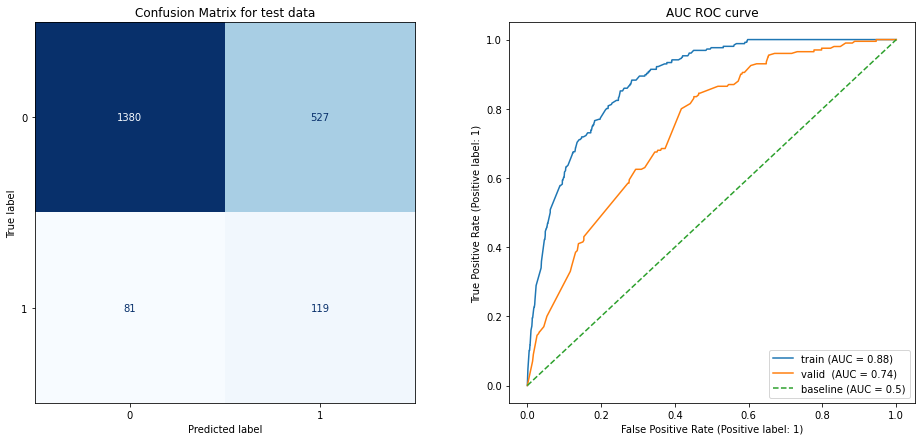

In [41]:
# plot the confusion matrix and ROC-AUC curve
plot_cm_roc(best_model, X_val, y_val)

In [75]:
# target distribution for validation data
y_val.value_counts()

0    1907
1     200
Name: wnv_present, dtype: int64

In [74]:
# recall
recall_score(y_val, best_model.predict(X_val))

0.595

The above two plots summarizes the best model performance really well. On the left is the confusion matrix, laying out the true negatives, false negatives, false positives, and true positives. Given the imbalance in the target variable for the validation data is almost 10:1, our model still predicted more than 50% of the positive class correctly. However, the false negatives are also quite high, at 527 about 25% were misclassified as being postive class, i.e. the virus was found when it is not. The reason for this is because of the oversampling of the minority class, which overtrains our model on the minority class.

On the right is the ROC-AUC score, which shows how well our model separates the two classes with 0.5 being the baseline. As we can see the training score is 0.88, which is quite high compared to the validation score of 0.74. The tuning of hyper-parameters in the grid search can help us reduce this gap further. Selecting adequate features and using feature interactions could also assist in improving the score. On that note, let's look at some of the features importances of the models.

### Feature importances

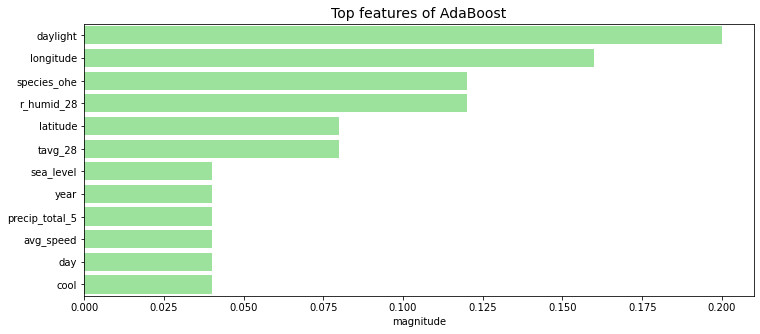

In [95]:
# Feature importances best model
importance = pd.DataFrame(best_model.best_estimator_.named_steps['ab'].feature_importances_,
                          index=X_train.columns).sort_values(by=0, ascending=False)
importance = importance[importance > 0].dropna().rename(columns={0: 'magnitude'})

# plot the importance values > 0
plt.figure(figsize=(12, 5))
plt.title("Top features of AdaBoost", fontdict={'fontsize': 14})
sns.barplot(data=importance, x='magnitude', y=importance.index, color='lightgreen');

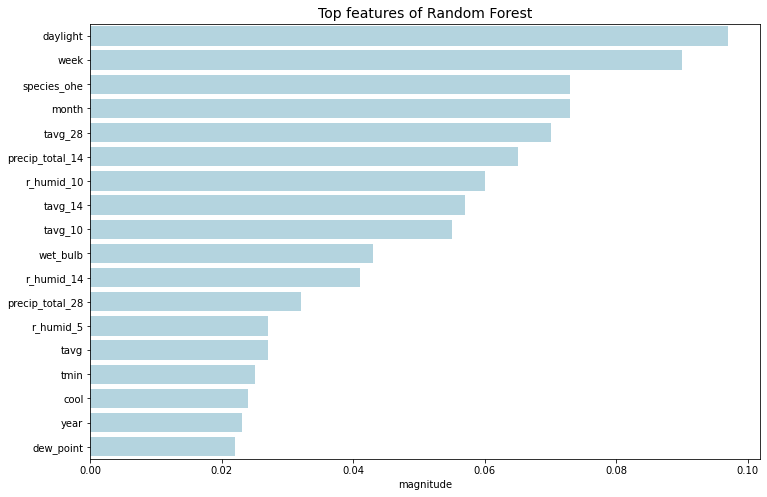

In [96]:
# Feature importances random forest
importance = pd.DataFrame(gs_dict['gs_rf'].best_estimator_.named_steps['rf'].feature_importances_,
                          index=X_train.columns).sort_values(by=0, ascending=False)
importance = importance[importance > 0.02].dropna().rename(columns={0: 'magnitude'})

# plot the importance values > 0
plt.figure(figsize=(12, 8))
plt.title("Top features of Random Forest", fontdict={'fontsize': 14})
sns.barplot(data=importance, x='magnitude', y=importance.index, color='lightblue');

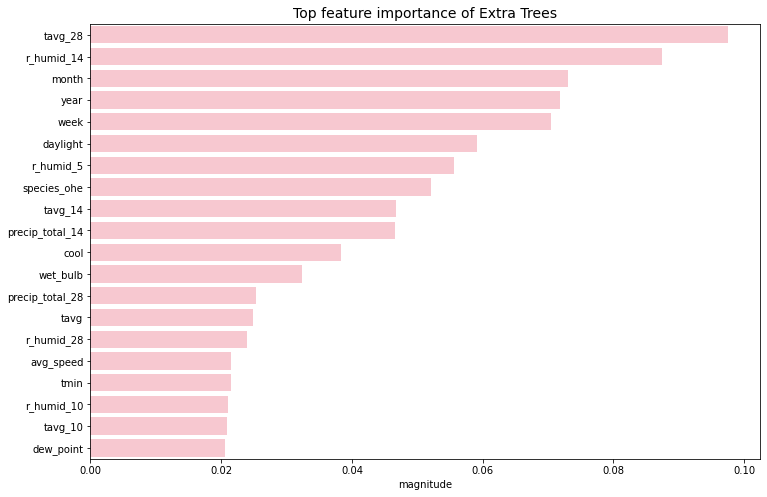

In [97]:
# Feature importances extra trees
importance = pd.DataFrame(gs_dict['gs_et'].best_estimator_.named_steps['et'].feature_importances_,
                          index=X_train.columns).sort_values(by=0, ascending=False)
importance = importance[importance > 0.02].dropna().rename(columns={0: 'magnitude'})

# plot the importance values > 0
plt.figure(figsize=(12, 8))
plt.title("Top feature importance of Extra Trees", fontdict={'fontsize': 14})
sns.barplot(data=importance, x='magnitude', y=importance.index, color='pink');

### Kaggle

In [147]:
best_model

GridSearchCV(estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('ab',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'ab__learning_rate': [0.8], 'ab__n_estimators': [25]},
             scoring='roc_auc', verbose=1)

In [148]:
#fit the best model with entire training data to make predictions for the test
best_model.best_estimator_.fit(X, y)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('ab',
                 AdaBoostClassifier(learning_rate=0.8, n_estimators=25,
                                    random_state=42))])

In [149]:
#save the kaggle submission file
get_kaggle_format(best_model.predict_proba(X_test)[:, 1])

File name: ../datasets/kaggle_sub_3.csv


## Recommendations and Conclusion